# Import

In [1]:
import comet_ml

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [3]:
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

In [4]:
import math
import os.path as osp
import pickle

In [5]:
import pytorch_lightning as pl

In [6]:
# from beetl.task_datasets import BeetlSleepTutorial, BeetlSleepSource, BeetlSleepLeaderboard, BeetlMILeaderboard
# ds = BeetlSleepSource()
# path = ds.download()
# print(path)
# X, y, info = ds.get_data()

In [7]:
# BeetlSleepLeaderboard().download()

# Settings and utils

In [8]:
SEED=997
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
pl.seed_everything(SEED)

Global seed set to 997


997

In [9]:
hyper_params = {
    'max_epochs': 30,
    'learning_rate': 0.003,
    'weight_decay': 0.01,
    'scheduler_patience': 10,
    'batch_size': 256,
    'dropout_conv': 0.1,
    'dropout_fc': 0.1,
    'early_stop_patience': 20,
    'weight_beta': 0.999,
    'focal_loss_gamma': 0.5
}

In [10]:
def plot_label_distribution(y):
    (unique, counts) = np.unique(np.asarray(y), return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    plt.bar(unique, counts)
    plt.show()

In [11]:
# for i in range(39):
#     _, y, _ = dataset.get_data(subjects=[i])
#     plot_label_distribution(y)

In [12]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load train, validation data

## Train data and validation data

Train data and validation data are from the same set of data and are assumed to be from one distribution.

In [13]:
from beetl.task_datasets import BeetlSleepSource
dataset = BeetlSleepSource()
from sklearn.model_selection import train_test_split

# X_train, y_train, info = dataset.get_data(subjects=range(0, 35))
# X_test, y_test, _ = dataset.get_data(subjects=range(35, 39))

X, y, _ = dataset.get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

(72436, 2, 3000)
[[    0 19257]
 [    1  6470]
 [    2 28763]
 [    3  4213]
 [    4  2400]
 [    5 11333]]


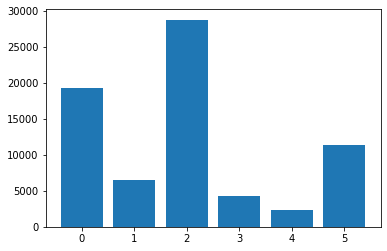

In [14]:
print(X_train.shape)
(unique, counts) = np.unique(np.asarray(y_train), return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
plt.bar(unique, counts)
plt.show()

In [21]:
loss_weight = np.power(hyper_params['weight_beta'], np.log(frequencies[:,1]))
loss_weight = (1 - hyper_params['weight_beta']) / (1 - loss_weight)
F.softmax(torch.tensor(loss_weight))

<ipython-input-21-5b785a1f6305>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(torch.tensor(loss_weight))


tensor([0.1650, 0.1671, 0.1643, 0.1681, 0.1695, 0.1660], dtype=torch.float64)

(18109, 2, 3000)
[[   0 4786]
 [   1 1471]
 [   2 7220]
 [   3 1034]
 [   4  657]
 [   5 2941]]


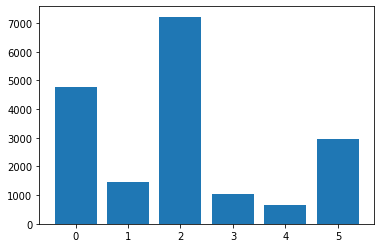

In [22]:
print(X_test.shape)
(unique, counts) = np.unique(np.asarray(y_test), return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
plt.bar(unique, counts)
plt.show()

In [23]:
X_train = np.delete(X_train, 1, 1)
X_test = np.delete(X_test, 1, 1)

From the above 2 histograms, we can see that they have similar labels' distribution.

In [24]:
%reset_selective -f "^X$"
%reset_selective -f "^y$"

# Dataloaders

In [25]:
from torch.utils.data import DataLoader, Dataset

class EEG1ChData(Dataset):
    def __init__(self, train_data, train_label, mode='train'):
        mean = np.mean(train_data, axis=2, keepdims=True)
        std = np.std(train_data, axis=2, keepdims=True)
        self.X = (train_data - mean) / std
        self.y = train_label
        self.mode = mode
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.mode == 'train':
#             shape = self.X[0].shape
#             noise = np.random.normal(0, 0.05, 6000).reshape(shape)
#             X = self.X[idx] + noise
            # randomly zero out 10 segments of length 50 to 100
            X = self.X[idx]
            zeroSegCount = np.random.randint(10)
            for i in range(zeroSegCount):
                s = np.random.randint(3000)
                l = np.random.randint(50, 100)
                for j in range(s, min(s + l, 3000)):
                    X[0][j] = 0
        else:
            X = self.X[idx]
        if self.y is not None:
            return torch.tensor(X, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
        else:
            return torch.tensor(X, dtype=torch.float32)

In [26]:
train_dataset = EEG1ChData(X_train, y_train)
test_dataset = EEG1ChData(X_test, y_test, mode='test')
print(train_dataset.X.shape) # should be length, 1, 3000

(72436, 1, 3000)


In [27]:
train_dataset[5][0].shape

torch.Size([1, 3000])

(array([ 12.,  29., 149., 660., 844., 872., 349.,  58.,  15.,  12.]),
 array([-3.83410592, -3.02822537, -2.22234482, -1.41646427, -0.61058373,
         0.19529682,  1.00117737,  1.80705792,  2.61293846,  3.41881901,
         4.22469956]),
 <BarContainer object of 10 artists>)

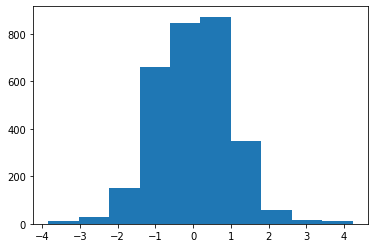

In [28]:
plt.hist(train_dataset.X[1][0])

In [29]:
from pytorch_metric_learning import samplers

In [30]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
#     sampler=samplers.MPerClassSampler(labels=y_train, m=hyper_params['batch_size'] // 6, 
#                                       length_before_new_iter=hyper_params['batch_size'] * 300), 
    shuffle=True,
    batch_size=hyper_params['batch_size'],
    pin_memory=True,
    num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=hyper_params['batch_size'], pin_memory=True, num_workers=2)

# Models

## Base Lightning Module

In [31]:
y_hat = torch.rand((10, 6), dtype=torch.float)
y = torch.randint(low=0, high=6, size=(10,))
print(y_hat)
print(y)
print(loss_weight)
print(F.cross_entropy(y_hat, y))
print(F.cross_entropy(y_hat, y, torch.tensor(loss_weight, dtype=torch.float)))

tensor([[0.0747, 0.2882, 0.5392, 0.3127, 0.2455, 0.1103],
        [0.8110, 0.5877, 0.0624, 0.7149, 0.3104, 0.8231],
        [0.0686, 0.4077, 0.6127, 0.6217, 0.1348, 0.1563],
        [0.9555, 0.6481, 0.4111, 0.9253, 0.2371, 0.2452],
        [0.2638, 0.5543, 0.8594, 0.1961, 0.2762, 0.6481],
        [0.6185, 0.0347, 0.1772, 0.4042, 0.6346, 0.5579],
        [0.7454, 0.0714, 0.0561, 0.3658, 0.8029, 0.2948],
        [0.5371, 0.8465, 0.9836, 0.2476, 0.1238, 0.5574],
        [0.9669, 0.9101, 0.6852, 0.8763, 0.2763, 0.6417],
        [0.6919, 0.1738, 0.7690, 0.7668, 0.2196, 0.1276]])
tensor([4, 1, 0, 5, 5, 1, 3, 4, 3, 0])
[0.10181214 0.11440475 0.09785305 0.12025965 0.12891786 0.1075655 ]
tensor(1.9068)
tensor(1.9103)


In [32]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses as loss_fn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix

    
class BaseNet(pl.LightningModule):
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        return {
            'loss': loss,
            'train_acc': torch.sum(torch.argmax(y_hat, axis=1) == y, dtype=torch.float32) / len(y)
        }
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in outputs]).mean()
        comet_logs = {'train_loss': avg_loss, 'train_acc': avg_acc}
        self.log_dict(comet_logs)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, axis=1)
        loss = self.loss_fn(y_hat, y)
        return {
            'val_loss': loss,
            'val_acc': torch.sum(preds == y, dtype=torch.float32) / len(y),
            'preds': torch.tensor(preds),
            'y': torch.tensor(y)
        }

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        comet_logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        
        targets = []
        predicted = []
        for x in outputs:
            targets.extend(x['y'])
            predicted.extend(x['preds'])
            
        targets = F.one_hot(torch.tensor(targets))
        predicted = F.one_hot(torch.tensor(predicted))
        
        experiment = self.logger.experiment
        experiment.log_confusion_matrix(
            targets,
            predicted,
            title="Confusion Matrix, Epoch #%d" % (self.current_epoch + 1),
            file_name="confusion-matrix-%03d.json" % (self.current_epoch + 1),
        )
        self.log_dict(comet_logs)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        return {
            'test_loss': loss,
            'test_acc': torch.sum(torch.argmax(y_hat, axis=1) == y, dtype=torch.float32) / len(y)
        }
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        comet_logs = {'test_loss': avg_loss, 'test_acc': avg_acc}
        self.log_dict(comet_logs)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=hyper_params['weight_decay'])
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=hyper_params['scheduler_patience'], min_lr=1e-5),
                'interval': 'epoch',
                'frequency': 1,
                'monitor': 'val_loss',
            }
        }

## Models

In [33]:
class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, drop_rate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, drop_rate)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, drop_rate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes,
                                out_planes,
                                i == 0 and stride or 1, drop_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)

        self.drop_rate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
            out = self.relu2(self.bn2(self.conv1(x)))
        else:
            out = self.relu1(self.bn1(x))
            out = self.relu2(self.bn2(self.conv1(out)))

        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)

        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

In [34]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [35]:
# import torch.nn as nn
# import torch.nn.functional as F
    
# class LSTMNet(nn.Module):
#     def __init__(self, n_classes):
#         super(LSTMNet, self).__init__()
#         self.drop1 = nn.Dropout(0.5)
#         self.drop_ch = nn.Dropout2d(0.1)
#         self.fc = nn.Linear(128, n_classes)
#         self.n_classes = n_classes

#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=[10, 2], stride=1)
#         self.bn1 = nn.BatchNorm1d(16)
        
#         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=10, stride=1)
#         self.bn2 = nn.BatchNorm1d(32)
        
#         self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=10, stride=1)
#         self.bn3 = nn.BatchNorm1d(64)
        
#         self.pool = nn.MaxPool1d(4)

#         self.lstm = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)

#         torch.nn.init.kaiming_normal_(self.conv1.weight)
#         torch.nn.init.kaiming_normal_(self.conv2.weight)
#         torch.nn.init.kaiming_normal_(self.conv3.weight)
#         torch.nn.init.kaiming_normal_(self.fc.weight)

#     def forward(self, x):
#         output = self.bn1(self.pool(F.relu(self.conv1(x)).reshape(x.shape[0], self.conv1.out_channels, -1)))
#         output = torch.squeeze(self.drop_ch(torch.unsqueeze(output, 3)))
        
#         output = self.bn2(self.pool(F.relu(self.conv2(output))))
#         output = torch.squeeze(self.drop_ch(torch.unsqueeze(output, 3)))
        
#         output = self.bn3(self.pool(F.relu(self.conv3(output))))
#         output = torch.squeeze(self.drop_ch(torch.unsqueeze(output, 3)))
#         # output's shape is batch, 64, 37
        
#         outputs, _ = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
# #         _, (outputs, _) = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
#         output = torch.mean(outputs, 1) # batch, hidden_size
# #         output = torch.squeeze(outputs)
#         output = F.relu(self.fc(self.drop1(output)))
#         return output


In [36]:
class WvNet(BaseNet):
    def __init__(self, learning_rate, drop_conv, drop_fc):
        super().__init__()
        
        self.loss_fn = FocalLoss(torch.tensor(loss_weight, dtype=torch.float), hyper_params['focal_loss_gamma'])
        self.learning_rate = learning_rate
        self.drop_fc = nn.Dropout(drop_fc)
        self.drop_conv = nn.Dropout2d(drop_conv)
        self.drop_sm = nn.Dropout(0.33)
        self.n_classes = 6
        self.conv_f_size = 32
        
        self.conv_fs = nn.ModuleList()
        for i in range(16):
            self.conv_fs.append(
                    nn.Sequential(OrderedDict([
                        ('conv', nn.Conv1d(in_channels=1, out_channels=self.conv_f_size, kernel_size=[5 * (i+1)], stride=1, bias=False)),
                        ('act', nn.ReLU()),
                        ('pool', nn.AdaptiveAvgPool1d((64))),
                        ('bn', nn.BatchNorm1d(self.conv_f_size))
                    ])
                )
            )

        self.pool_conv_1 = nn.AvgPool2d((2, 2))
        self.conv_gr1 = nn.Conv2d(in_channels=len(self.conv_fs), out_channels=16, kernel_size=[3, 7], stride=1, padding=(1, 3), groups=1)
        self.bn_gr1 = nn.BatchNorm2d(self.conv_gr1.out_channels)
        
        self.conv_gr2 = nn.Conv2d(in_channels=self.conv_gr1.out_channels, out_channels=48, kernel_size=[3, 7], stride=1, padding=(1, 3), groups=1)
        self.pool_conv_2 = nn.AvgPool2d((2, 1))
        self.bn_gr2 = nn.BatchNorm2d(self.conv_gr2.out_channels)
        
        self.conv_gr3 = nn.Conv2d(in_channels=self.conv_gr2.out_channels, out_channels=128, kernel_size=[8, 8], stride=1, groups=2)
        self.bn_gr3 = nn.BatchNorm2d(self.conv_gr3.out_channels)
        
        self.lstm = nn.LSTM(input_size=self.conv_gr3.out_channels, hidden_size=128, bidirectional=True, batch_first=True)
#         self.fc2 = nn.Linear(48, self.n_classes)
        
#         self.fc = nn.Linear(128, self.n_classes)
#         self.fc1 = nn.Linear(128, 48)
#
        # depthwise convolution acts as FC layer
        self.dw_conv = nn.Conv1d(in_channels=256, out_channels=6, kernel_size=[1], stride=1)

        
        for conv_f in self.conv_fs:
            torch.nn.init.kaiming_normal_(conv_f.conv.weight)
        torch.nn.init.kaiming_normal_(self.conv_gr1.weight)
        torch.nn.init.kaiming_normal_(self.conv_gr2.weight)
        torch.nn.init.kaiming_normal_(self.conv_gr3.weight)
        torch.nn.init.kaiming_normal_(self.dw_conv.weight)
#         torch.nn.init.kaiming_normal_(self.fc1.weight)
#         torch.nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        outputs = []
        for i in range(len(self.conv_fs)):
            output = self.conv_fs[i](x)
            output = self.drop_conv(output)
            output = torch.squeeze(output)
            outputs.append(output)
        
        output = torch.stack((outputs), dim=1)
        
        output = self.bn_gr1(self.pool_conv_1(F.relu(self.conv_gr1(output))))
        output = self.drop_conv(output)
        
        output = self.bn_gr2(self.pool_conv_2(F.relu(self.conv_gr2(output))))
        output = self.drop_conv(output)
        
        output = self.bn_gr3(F.relu(self.conv_gr3(output)))
        output = torch.squeeze(output)
        
#         _, (outputs, _) = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
#         output = outputs[1] # get hidden of backward pass

        outputs, _ = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
        outputs = self.dw_conv(torch.transpose(outputs, 2, 1))
        output = torch.mean(outputs, dim=2) # batch, 6

#         output = F.relu(self.fc1(self.drop_fc(output)))
#         output = self.fc2(self.drop_fc(output))
        return output

    def configure_optimizers(self):
        optimizer = optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=hyper_params['weight_decay'])
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler.OneCycleLR(optimizer, max_lr=hyper_params['learning_rate'], steps_per_epoch=len(train_loader), epochs=hyper_params['max_epochs'], pct_start=0.3, div_factor=3),
                'interval': 'step',
                'frequency': 1
            }
        }

In [31]:
class WvConvNet(BaseNet):
    def __init__(self, learning_rate, depth, widen_factor=1, drop_rate=0.5, flatten=True, stride=1):
        super(WvConvNet, self).__init__()
        self.drop_fc = nn.Dropout(0.1)
        self.drop_conv = nn.Dropout2d(0.1)
        self.n_classes = 6
        self.learning_rate = learning_rate
        self.conv_f_size = 32
        
        self.conv_fs = nn.ModuleList()
        self.bn_fs = nn.ModuleList()
        self.pool_fs = nn.ModuleList()
        for i in range(16):
            self.conv_fs.append(nn.Conv1d(in_channels=1, out_channels=self.conv_f_size, kernel_size=[5], stride=1, dilation=(2*(i+1))))
            self.bn_fs.append(nn.BatchNorm1d(self.conv_f_size))
            self.pool_fs.append(nn.AdaptiveAvgPool1d(32))

        n_channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]

        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        #self.conv1 = nn.Conv2d(4, n_channels[0], kernel_size=3, stride=1,
        #                       padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, n_channels[0], n_channels[1], block, stride, drop_rate)
        # 2nd block
        self.block2 = NetworkBlock(n, n_channels[1], n_channels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(n, n_channels[2], n_channels[3], block, 2, drop_rate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(n_channels[3])
        self.relu = nn.ReLU(inplace=True)
        self.nChannels = n_channels[3]

        self.linear = nn.Linear(640, self.n_classes)

        if flatten:
            self.final_feat_dim = 640
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    
        for conv in self.conv_fs:
            torch.nn.init.kaiming_normal_(conv.weight)

    def forward(self, x):
        outputs = []
        for i in range(len(self.conv_fs)):
            output = F.relu(self.conv_fs[i](x))
            output = self.bn_fs[i](self.pool_fs[i](output))
#             output = self.drop_conv(output)
            output = torch.squeeze(output)
            outputs.append(output)
        
        output = torch.stack((outputs), dim=1)
#         output = self.drop_conv(output)
        
        # print(output.shape)

        #out = self.conv1(output)
        out = self.block1(output)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, out.size()[2:])
        out = out.view(x.size(0), -1)

        logits = F.relu(self.linear(self.drop_fc(out)))

        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return {
            'loss': loss,
            'train_acc': torch.sum(torch.argmax(y_hat, axis=1) == y, dtype=torch.float32) / len(y)
        }
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=hyper_params['weight_decay'])
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler.OneCycleLR(optimizer, max_lr=hyper_params['learning_rate'], steps_per_epoch=300, epochs=hyper_params['max_epochs'], pct_start=0.3, div_factor=3),
                'interval': 'step',
                'frequency': 1
            }
        }

# Training

## Create trainer

In [37]:
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint

comet_config = {
    'api_key': 'WRx11j64HCTDOp2MpXBExSTdI',
    'project_name': 'sleep-eeg',
    'workspace': 'peara',
}

# arguments made to CometLogger are passed on to the comet_ml.Experiment class
comet_logger = CometLogger(
    api_key=comet_config['api_key'],
    workspace=comet_config['workspace'],
    project_name=comet_config['project_name'],
    experiment_name='WvNet 16 channel + 5 * i + 32 features'
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=hyper_params['early_stop_patience'],
    min_delta=0.0005,
    verbose=False,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='../models/',
    filename='wvnet-1ch-{epoch}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(gpus=1, max_epochs=hyper_params['max_epochs'], logger=comet_logger, deterministic=True, callbacks=[lr_monitor, checkpoint_callback], stochastic_weight_avg=True)

CometLogger will be initialized in online mode
/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory ../models/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [38]:
trainer.logger.log_hyperparams(hyper_params)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/peara/sleep-eeg/43682b9f14f54e1ea2fdf7ee3a14e278



## Fit

In [39]:
model = WvNet(hyper_params['learning_rate'], hyper_params['dropout_conv'], hyper_params['dropout_fc'])

In [40]:
trainer.fit(model, train_loader, val_dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: Empty mapping given to log_params({}); ignoring

   | Name        | Type        | Params
---------------------------------------------
0  | loss_fn     | FocalLoss   | 0     
1  | drop_fc     | Dropout     | 0     
2  | drop_conv   | Dropout2d   | 0     
3  | drop_sm     | Dropout     | 0     
4  | conv_fs     | ModuleList  | 22.8 K
5  | pool_conv_1 | AvgPool2d   | 0     
6  | conv_gr1    | Conv2d      | 5.4 K 
7  | bn_gr1      | BatchNorm2d | 32    
8  | conv_gr2    | Conv2d      | 16.2 K
9  | pool_conv_2 | AvgPool2d   | 0     
10 | bn_gr2      | BatchNorm2d | 96    
11 | conv_gr3    | Conv2d      | 196 K 
12 | bn_gr3      | BatchNorm2d | 256   
13 | lstm        | LSTM        | 264 K 
14 | dw_conv     | Conv1d      | 1.5 K 
---------------------------------------------
507 K     Trainable params
0         Non-trainable params
507 K     Total params
2.029     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
<ipython-input-32-f25f14810599>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'preds': torch.tensor(preds),
<ipython-input-32-f25f14810599>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'y': torch.tensor(y)
Global seed set to 997
/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_load

Training: 0it [00:00, ?it/s]

/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/callback_hook.py:100: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/stochastic_weight_avg.py:199: UserWarning: SWA is currently only supported every epoch. Found {'scheduler': <torch.optim.lr_scheduler.OneCycleLR object at 0x7f3f647ce640>, 'name': None, 'interval': 'step', 'frequency': 1, 'reduce_on_plateau': False, 'monitor': None, 'strict': True, 'opt_idx': None}
  rank_zero_warn(f"SWA is currently only supported every epoch. Found {scheduler_cfg}")
Swapping scheduler <torch.optim.lr_scheduler.OneCycleLR object at 0x7f3f647ce640> for <torch.optim.swa_utils.SWALR object at 0x7f404b1a13d0>


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/peara/sleep-eeg/43682b9f14f54e1ea2fdf7ee3a14e278
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [1710]     : (0.12380684167146683, 1.6475012302398682)
COMET INFO:     lr-AdamW [169]  : (0.000749388429312009, 0.002999998113844519)
COMET INFO:     train_acc [31]  : (0.7141798734664917, 0.8619987368583679)
COMET INFO:     train_loss [31] : (0.20204006135463715, 0.5532103776931763)
COMET INFO:     val_acc [31]    : (0.7650579214096069, 0.8221216797828674)
COMET INFO:     val_loss [31]   : (0.2914925217628479, 0.42746105790138245)
COMET INFO:   Others:
COMET INFO:     Name : WvNet 16 channel + 5 * i + 32 features
COMET INFO:   Parameters:
COMET INFO:     batch_size          : 256
COMET INFO:     dropout_conv        : 0.1
COMET INFO:    

In [41]:
%reset_selective -f "^train_loader$"
%reset_selective -f "^train_dataset$"

In [42]:
%reset_selective -f "^test_loader$"
%reset_selective -f "^test_dataset$"

## Test

### Test data

Test data is from a different set of subjects and have a different distribution.

In [43]:
from beetl.task_datasets import BeetlSleepLeaderboard
X_sleep_target, y_sleep_target, _, _ = BeetlSleepLeaderboard().get_data(subjects=range(0, 6))

(15442, 1, 3000)


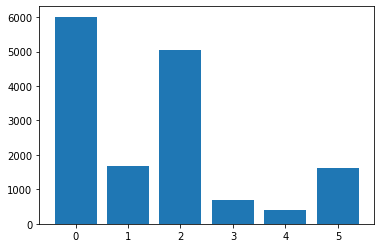

In [44]:
X_sleep_target = np.delete(X_sleep_target, 1, 1)
print(X_sleep_target.shape)
(unique, counts) = np.unique(y_sleep_target, return_counts=True)
plt.bar(unique, counts)
plt.show()

In [45]:
transfer_dataset = EEG1ChData(X_sleep_target, y_sleep_target, mode='test')
transfer_loader = torch.utils.data.DataLoader(dataset=transfer_dataset, batch_size=hyper_params['batch_size'], pin_memory=True, num_workers=2)

### Evaluate

In [46]:
model = WvNet.load_from_checkpoint(checkpoint_callback.best_model_path, learning_rate=0.01, drop_conv=0.1, drop_fc=0.1)

In [47]:
trainer.test(model, transfer_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/peara/sleep-eeg/43682b9f14f54e1ea2fdf7ee3a14e278

/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7549744844436646, 'test_loss': 0.46065324544906616}
--------------------------------------------------------------------------------


[{'test_loss': 0.46065324544906616, 'test_acc': 0.7549744844436646}]

In [48]:
trainer.logger.experiment.end()

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/peara/sleep-eeg/43682b9f14f54e1ea2fdf7ee3a14e278
COMET INFO:   Metrics:
COMET INFO:     test_acc  : 0.7549744844436646
COMET INFO:     test_loss : 0.46065324544906616
COMET INFO:   Others:
COMET INFO:     Name : WvNet 16 channel + 5 * i + 32 features
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: -----------------------------------
COMET INFO: Uploading 1 metrics, params and output messages


In [47]:
%reset_selective -f "^transfer_loader$"
%reset_selective -f "^transfer_dataset$"

# TODO

In [52]:
f = model.conv_fs[5].conv.weight[2][0].cpu().detach().numpy()
f

array([ 0.25758243,  0.47651964,  0.13657297, -0.02316955, -0.01034138,
       -0.38634613,  0.01957973,  0.51575965,  0.5079736 ,  0.18365107,
        0.0541507 , -0.31158885,  0.18341897, -0.06970672, -0.09294304,
       -0.10862093,  0.01193714, -0.41946396,  0.03424583, -0.29537013,
       -0.2428208 ,  0.48377186, -0.05305401,  0.46856695, -0.17357403,
       -0.1471026 , -0.13944083,  0.46226388,  0.5698198 ,  0.2916519 ],
      dtype=float32)

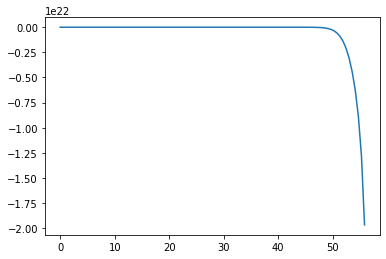

In [53]:
from scipy import signal
t, y = signal.impulse(([1.0], f))
import matplotlib.pyplot as plt
plt.plot(t, y)

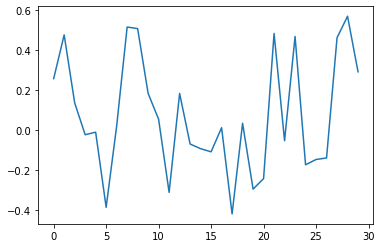

In [54]:
plt.plot(f)

In [ ]:
trainer.save_checkpoint("../models/wvnet.ckpt")

# Submission

In [55]:
from beetl.task_datasets import BeetlSleepLeaderboard
_, _, X_sleep_test, _ = BeetlSleepLeaderboard().get_data(subjects=range(6, 18))

In [56]:
X_sleep_test = np.delete(X_sleep_test, 1, 1)
submission_dataset = EEG1ChData(X_sleep_test, None, mode='test')
submission_loader = torch.utils.data.DataLoader(dataset=submission_dataset, batch_size=128)

In [46]:
trainer = pl.Trainer(gpus=1, deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [57]:
model = WvNet.load_from_checkpoint(checkpoint_callback.best_model_path, learning_rate=0.01, drop_conv=0, drop_fc=0)

In [58]:
predicts = trainer.predict(model, submission_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 283it [00:00, ?it/s]

In [59]:
predicted_labels = []
for predicts in predicts:
    predicted_labels.extend(np.argmax(predicts.cpu().detach().numpy(), axis=1))

In [60]:
print(predicted_labels[:20])
np.savetxt("answer.txt",predicted_labels,delimiter=',',fmt="%d")

[1, 5, 2, 2, 5, 2, 0, 1, 2, 2, 2, 2, 5, 5, 0, 5, 2, 2, 2, 0]


In [61]:
print(len(predicted_labels))

25748


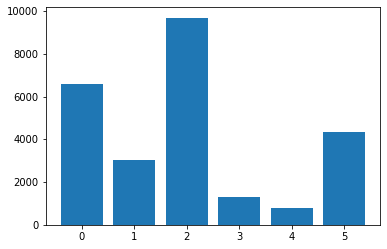

In [62]:
plot_label_distribution(predicted_labels)